In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment
from src.runner import runner
from src.helpers import confidence_interval
from sklearn import preprocessing
import random
import json
import os

In [2]:
style.use('seaborn-white')

# Initialise small 2 district model

In [3]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

In [4]:
TIME = 60

In [5]:
parameters = {
     # general simulation parameters
    "time": TIME,
    "number_of_agents": 50,
    "monte_carlo_runs": 1,
    
    # Cape Town specific parameters
    "total_initial_infections": [x for x in range(0, 19)], # total agents infected in CT
    "health_system_capacity": 0.0021, # relative (in terms of population) capacity of the hospitals
    
    # COVID-19 parameters
    "exposed_days": 4, # average number of days without symptoms and being able to infect others
    "asymptom_days": 10, # average number of days agents are infected but do not have symptoms
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 8, # average number of days agents are in critical condition
    "probability_symptomatic": 0.6165, # determines whether an agent will become asymptomatic or asymptomatic spreader
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "probability_transmission": 0.05, # should be estimated to replicate realistic R0 number.
    
    "probability_critical": {key:value for key, value in zip(age_groups, [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])}, # probability that an agent enters a critical stage of the disease SOURCE: Verity et al.
    "probability_to_die": {key:value for key, value in zip(age_groups, [0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])}, # probability to die per age group in critical stage SOURCE: Verity et al.
    
    # Policy parameters
    "lockdown_days" : [None for x in range(0, TIME)], # in the baseline this is 0, 5 march was the first reported case, 27 march was the start of the lockdown 35 days 
    "informality_dummy": 1.0, # setting this parameter at 0 will mean the lockdown is equally effective anywhere, alternative = 1
    
    # Specific policy parameters
    # (1) physical distancing measures such as increased hygiëne & face mask adoption 
    "physical_distancing_multiplier": 0.27, # Jarvis et al. 2020,
    # (2) reducing travel e.g. by reducing it for work, school or all
    "visiting_recurring_contacts_multiplier": 0.6, # depending on how strict the lockdown is at keeping you put.
    # (3) Testing and general awareness
    'likelihood_awareness': 0.6, # this will be increased through track & trace and coviid
    'self_isolation_multiplier': 0.4, # determines the percentage of connections cut thanks to self-isoluation can go up with coviid
    'aware_status': ['i2'], # i1 can be added if there is large scale testing 
    # (4) limiting mass contact e.g. forbidding large events
    "gathering_max_contacts": 6,
    
    # Technical parameters
    'init_infected_agent': 0, # to calculate R0
    "data_output": 'network', # 'csv' or 'network', or 'False'
    
    # Depreciated paramters (can be used later)
    "probability_susceptible": 0.000, # probability that the agent will again be susceptible after having recovered
}

In [6]:
districts_data = [[1, {'Population': round(parameters['number_of_agents'] / 2),
                                                 'Density': 1.0,
                                                 'lon': 1.0,
                                                 'lat': 1.0,
                                                 'Informal_residential': 0.0,
                                                 'Cases_With_Subdistricts': 0.5,
                                                }],
                 [2, {'Population': round(parameters['number_of_agents'] / 2),
                                                 'Density': 1.0,
                                                 'lon': 2.0,
                                                 'lat': 2.0,
                                                 'Informal_residential': 0.0,
                                                 'Cases_With_Subdistricts': 0.5,
                                                }]]

In [7]:
a_distribution =  [0.112314, 0.118867, 0.145951, 0.145413, 0.151773, 0.139329, 0.099140, 0.058729, 0.028484]

Age distribution per district only has one district and accompanying distribution. 

In [8]:
age_distribution_per_district = {1: pd.Series(a_distribution, index=age_groups), 2: pd.Series(a_distribution, index=age_groups)}

The distance matrix is assumes that there is an equal opportunity for tavel between and within the two districts

In [9]:
travel_matrix = {districts_data[0][0]: [0.5, 0.5], districts_data[1][0]: [0.5, 0.5]}
travel_matrix = pd.DataFrame(travel_matrix).transpose()
travel_matrix.columns = [str(districts_data[0][0]), str(districts_data[1][0])]

In [11]:
travel_matrix

,1,2
1,0.5,0.5
2,0.5,0.5


**Contact matrices**

In [12]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

hh_contact_matrix = pd.read_excel('input_data/ContactMatrices_10year.xlsx', sheet_name="Home", index_col=0)
hh_contact_matrix['80plus'] = hh_contact_matrix['70_80']
row = hh_contact_matrix.xs('70_80')
row.name = '80plus'
hh_contact_matrix = hh_contact_matrix.append(row)
hh_contact_matrix.columns = age_groups
hh_contact_matrix.index = age_groups

In [13]:
other_contact_matrix = pd.read_excel('input_data/ContactMatrices_10year.xlsx', sheet_name="OutsideOfHome", index_col=0)
other_contact_matrix['80plus'] = other_contact_matrix['70_80']
row = other_contact_matrix.xs('70_80')
row.name = '80plus'
other_contact_matrix = other_contact_matrix.append(row)

In [14]:
other_contact_matrix.columns = age_groups
other_contact_matrix.index = age_groups

**Household size distribution for the two districts**

For this, we use the household size distribution the first two districts in Cape Town

In [15]:
HH_size_distribution = pd.read_excel('input_data/HH_Size_Distribution.xlsx', index_col=0)
HH_size_distribution = HH_size_distribution.iloc[0:2]
HH_size_distribution.index = [1, 2]
HH_size_distribution

,1,2,3,4,5,6,7,8,9,10,...,246,247,248,249,250,251,255,256,262,Total
1,2064.10336,2851.54289,1627.27746,1572.17372,675.87276,237.09030,79.31132,33.39424,6.26142,2.08714,...,0,0,0,0,0,0,0,0,0,9170.33246
2,2798.57376,2894.32048,1837.07722,1639.96986,672.92960,314.03824,115.61842,44.82994,14.56641,7.26142,...,0,0,0,0,0,0,0,0,0,10366.49034


In [16]:
data_folder = 'measurement/simple/'

if not os.path.exists('{}seed{}'.format(data_folder, 0)):
    os.makedirs('{}seed{}'.format(data_folder, 0))

# Simulation

In [17]:
data_folder = 'measurement/simple/'

if not os.path.exists('{}seed{}'.format(data_folder, 0)):
    os.makedirs('{}seed{}'.format(data_folder, 0))
    
environment = Environment(0, parameters, districts_data, age_distribution_per_district, 
                         hh_contact_matrix, other_contact_matrix, HH_size_distribution, travel_matrix)
environment = runner(environment, 0, data_output='network', data_folder=data_folder)


# Analysis

In [18]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

In [19]:
pos = nx.spring_layout(environment.infection_states[0])

In [20]:
def plot_model(t):
    network = environment.infection_states[t]
    color_map = []
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            color_map.append('blue')
        elif network.nodes[idx]['agent'] == 'e':
            color_map.append('pink')
        elif network.nodes[idx]['agent'] == 'i1':
            color_map.append('purple')
        elif network.nodes[idx]['agent'] == 'i2':
            color_map.append('red')
        elif network.nodes[idx]['agent'] == 'c':
            color_map.append('brown')
        elif network.nodes[idx]['agent'] == 'd':
            color_map.append('black')
        elif network.nodes[idx]['agent'] == 'r':
            color_map.append('grey')
    nx.draw(network, pos=pos, node_color=color_map, with_labels=True)

In [21]:
time_period = wg.IntSlider(description='Time step', min=0, max=parameters['time']-1)
wg.interact(plot_model, t=time_period)

interactive(children=(IntSlider(value=0, description='Time step', max=59), Output()), _dom_classes=('widget-in…

<function __main__.plot_model(t)>

In [22]:
susceptible_ot = []
exposed_ot = []
infected_1_ot = []
infected_2_ot = []
critical_ot = []
dead_ot = []
recovered_ot = []

for t in range(parameters['time']):
    network = environment.infection_states[t]
    susceptible = 0
    exposed = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'e':
            exposed += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot.append((susceptible / float(len(network))))
    infected_1_ot.append((infected_1 / float(len(network))))
    infected_2_ot.append((infected_2 / float(len(network))))
    critical_ot.append((critical / float(len(network))))
    dead_ot.append((dead / float(len(network))) )
    recovered_ot.append((recovered / float(len(network))) )
    exposed_ot.append((exposed / float(len(network))) )

(0, 1)

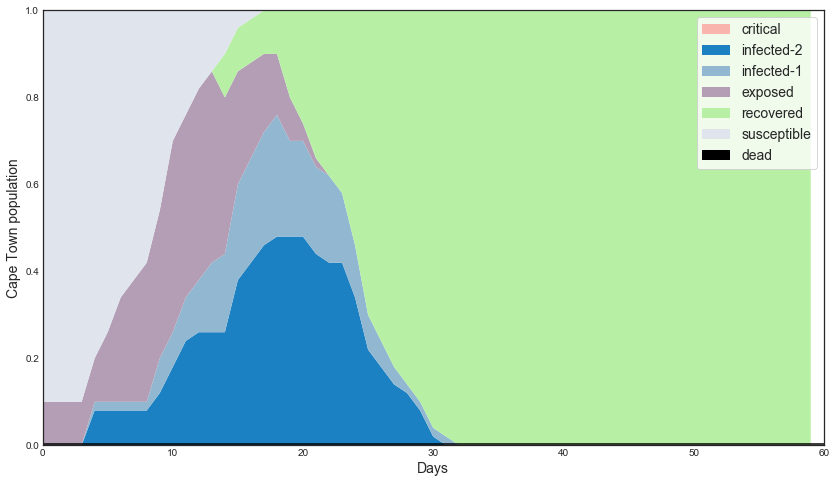

In [23]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical','infected-2', 'infected-1', 'exposed', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, exposed_ot, recovered_ot, susceptible_ot, dead_ot])

ax.axhline(parameters['health_system_capacity'], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b39eb5", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')


plt.xlim([0,parameters['time']])
plt.ylim([0, 1])